In [1]:
import os
import json
import random
import math
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
import torchaudio
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Бинарная классификация аудиофайлов

В основном код взят из https://github.com/re9ulus/BC-ResNet

In [6]:
EPS = 1e-9
SAMPLE_RATE = 16000
WINDOW_SIZE = 1.5  # сек
HOP_SIZE = 0.5     # сек

class KeywordDataset(Dataset):
    def __init__(self, audio_dir, bounds_json):
        self.audio_dir = audio_dir
        self.window_size = WINDOW_SIZE
        self.hop_size = HOP_SIZE

        with open(bounds_json) as f:
            self.bounds = json.load(f)  # {"id": [start, end], ...}

        self.audio_files = []
        for fname in os.listdir(audio_dir):
            if fname.endswith(".opus") and not fname.startswith("._"):
                uid = fname.split(".")[0]
                path = os.path.join(audio_dir, fname)
                self.audio_files.append((uid, path))

        # Mel transform
        self.to_mel = transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE, n_fft=1024, f_max=8000, n_mels=40
        )

    def __len__(self):
        return len(self.audio_files)

    def _prepare_wav(self, waveform, sr):
        if sr != SAMPLE_RATE:
            waveform = transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(waveform)
        return waveform

    def __getitem__(self, idx):
        uid, path = self.audio_files[idx]
        wav, sr = torchaudio.load(path)
        wav = self._prepare_wav(wav, sr)
        wav = wav.mean(0, keepdim=True)  # моно

        duration = wav.shape[1] / SAMPLE_RATE
        win_len = int(self.window_size * SAMPLE_RATE)
        hop_len = int(self.hop_size * SAMPLE_RATE)

        start_end = self.bounds.get(uid, None)

        segments, labels = [], []
        for start in range(0, wav.shape[1] - win_len + 1, hop_len):
            end = start + win_len
            seg = wav[:, start:end]

            # метка
            label = 0
            if start_end is not None:
                s, e = start_end
                t0, t1 = start / SAMPLE_RATE, end / SAMPLE_RATE
                if not (t1 < s or t0 > e):  # пересечение с ключевой фразой
                    label = 1

            # Mel
            log_mel = (self.to_mel(seg) + EPS).log2()
            segments.append(log_mel)
            labels.append(label)

        # возвращаем все окна как батч
        segments = torch.stack(segments)  # [num_windows, n_mels, time]
        labels = torch.tensor(labels, dtype=torch.long)

        return segments, labels


def collate_fn(batch):
    # batch = [(segments, labels), ...]
    xs, ys = [], []
    for segs, labels in batch:
        xs.append(segs)
        ys.append(labels)
    xs = torch.cat(xs, dim=0)
    ys = torch.cat(ys, dim=0)
    return xs, ys

In [7]:
# Параметры
AUDIO_DIR = "/kaggle/input/kws-train-attempt2/train_opus/audio"           # путь к папке с аудио
BOUNDS_JSON = "/kaggle/input/kws-train-attempt2/train_opus/word_bounds.json"  # json с таймингами
BATCH_SIZE = 256
VAL_SPLIT = 0.1
NUM_WORKERS = 4  # на Windows можно поставить 0

# Загружаем полный датасет
full_dataset = KeywordDataset(audio_dir=AUDIO_DIR, bounds_json=BOUNDS_JSON)

# Разделяем на train / validation
val_len = int(len(full_dataset) * VAL_SPLIT)
train_len = len(full_dataset) - val_len
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [39]:
val_loader = DataLoader(
    val_dataset,
    batch_size=1024,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True
)


In [10]:
from torch import nn


class SubSpectralNorm(nn.Module):
    def __init__(self, channels, sub_bands, eps=1e-5):
        super().__init__()
        self.sub_bands = sub_bands
        self.bn = nn.BatchNorm2d(channels*sub_bands, eps=eps)

    def forward(self, x):
        N, C, F, T = x.size()
        x = x.view(N, C * self.sub_bands, F // self.sub_bands, T)
        x = self.bn(x)
        return x.view(N, C, F, T)


In [11]:
DROPOUT = 0.1


class NormalBlock(nn.Module):
    def __init__(self, n_chan: int, *, dilation: int = 1, dropout: float = DROPOUT, use_subspectral: bool = True):
        super().__init__()
        norm_layer = SubSpectralNorm(n_chan, 5) if use_subspectral else nn.BatchNorm2d(n_chan)
        self.f2 = nn.Sequential(
            nn.Conv2d(n_chan, n_chan, kernel_size=(3, 1), padding="same", groups=n_chan),
            norm_layer,
        )
        self.f1 = nn.Sequential(
            nn.Conv2d(n_chan, n_chan, kernel_size=(1, 3), padding="same", groups=n_chan, dilation=(1, dilation)),
            nn.BatchNorm2d(n_chan),
            nn.SiLU(),
            nn.Conv2d(n_chan, n_chan, kernel_size=1),
            nn.Dropout2d(dropout)
        )
        self.activation = nn.ReLU()

    def forward(self, x):
        n_freq = x.shape[2]
        x1 = self.f2(x)

        x2 = torch.mean(x1, dim=2, keepdim=True)
        x2 = self.f1(x2)
        x2 = x2.repeat(1, 1, n_freq, 1)

        return self.activation(x + x1 + x2)


class TransitionBlock(nn.Module):
    def __init__(self, in_chan: int, out_chan: int, *, dilation: int = 1, stride: int = 1, dropout: float = DROPOUT, use_subspectral: bool = True):
        super().__init__()

        if stride == 1:
            conv = nn.Conv2d(out_chan, out_chan, kernel_size=(3, 1), groups=out_chan, padding="same")
        else:
            conv = nn.Conv2d(out_chan, out_chan, kernel_size=(3, 1), stride=(stride, 1), groups=out_chan, padding=(1, 0))

        norm_layer = SubSpectralNorm(out_chan, 5) if use_subspectral else nn.BatchNorm2d(out_chan)
        self.f2 = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=(1, 1)),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            conv,
            norm_layer,
        )

        self.f1 = nn.Sequential(
            nn.Conv2d(out_chan, out_chan, kernel_size=(1, 3), padding="same", groups=out_chan, dilation=(1, dilation)),
            nn.BatchNorm2d(out_chan),
            nn.SiLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=1),
            nn.Dropout2d(dropout)
        )

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.f2(x)
        n_freq = x.shape[2]
        x1 = torch.mean(x, dim=2, keepdim=True)
        x1 = self.f1(x1)
        x1 = x1.repeat(1, 1, n_freq, 1)

        return self.activation(x + x1)


class BcResNetModel(nn.Module):
    def __init__(self, n_class: int = 35, *, scale: int = 1, dropout: float = DROPOUT, use_subspectral: bool = True):
        super().__init__()

        self.input_conv = nn.Conv2d(1, 16*scale, kernel_size=(5, 5), stride=(2, 1), padding=2)

        self.t1 = TransitionBlock(16*scale, 8*scale, dropout=dropout, use_subspectral=use_subspectral)
        self.n11 = NormalBlock(8*scale, dropout=dropout, use_subspectral=use_subspectral)

        self.t2 = TransitionBlock(8*scale, 12*scale, dilation=2, stride=2, dropout=dropout, use_subspectral=use_subspectral)
        self.n21 = NormalBlock(12*scale, dilation=2, dropout=dropout, use_subspectral=use_subspectral) 

        self.t3 = TransitionBlock(12*scale, 16*scale, dilation=4, stride=2, dropout=dropout, use_subspectral=use_subspectral)
        self.n31 = NormalBlock(16*scale, dilation=4, dropout=dropout, use_subspectral=use_subspectral)
        self.n32 = NormalBlock(16*scale, dilation=4, dropout=dropout, use_subspectral=use_subspectral)
        self.n33 = NormalBlock(16*scale, dilation=4, dropout=dropout, use_subspectral=use_subspectral)

        self.t4 = TransitionBlock(16*scale, 20*scale, dilation=8, dropout=dropout, use_subspectral=use_subspectral)
        self.n41 = NormalBlock(20*scale, dilation=8, dropout=dropout, use_subspectral=use_subspectral)
        self.n42 = NormalBlock(20*scale, dilation=8, dropout=dropout, use_subspectral=use_subspectral)
        self.n43 = NormalBlock(20*scale, dilation=8, dropout=dropout, use_subspectral=use_subspectral)

        self.dw_conv = nn.Conv2d(20*scale, 20*scale, kernel_size=(5, 5), groups=20)
        self.onexone_conv = nn.Conv2d(20*scale, 32*scale, kernel_size=1)

        self.head_conv = nn.Conv2d(32*scale, n_class, kernel_size=1)
    
    def forward(self, x: torch.Tensor):
        x = self.input_conv(x)
        x = self.t1(x)
        x = self.n11(x)

        x = self.t2(x)
        x = self.n21(x)

        x = self.t3(x)
        x = self.n31(x)
        x = self.n32(x)
        x = self.n33(x)

        x = self.t4(x)
        x = self.n41(x)
        x = self.n42(x)
        x = self.n43(x)

        x = self.dw_conv(x)
        x = self.onexone_conv(x)

        x = torch.mean(x, dim=3, keepdim=True)
        x = self.head_conv(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)


In [14]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    return tensor.argmax(dim=-1)


def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        pred = model(data)
        pred = get_likely_index(pred)

        correct += number_of_correct(pred, target)

    score = correct / len(data_loader.dataset)
    return score


def apply_to_wav(model, waveform: torch.Tensor, sample_rate: float, device: str):
    model.eval()
    mel_spec = get_data.prepare_wav(waveform, sample_rate)
    mel_spec = torch.unsqueeze(mel_spec, dim=0).to(device)
    res = model(mel_spec)

    probs = torch.nn.Softmax(dim=-1)(res).cpu().detach().numpy()
    predictions = []
    for idx in np.argsort(-probs):
        label = get_data.idx_to_label(idx)
        predictions.append((label, probs[idx]))
    return predictions


def apply_to_file(model, wav_file: str, device: str):
    waveform, sample_rate = torchaudio.load(wav_file)
    return apply_to_wav(model, waveform, sample_rate, device)

In [12]:
@torch.no_grad()
def validate_epoch(model, val_loader, device):
    model.eval()

    losses = []
    correct = 0

    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        losses.append(loss.item())

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    avg_loss = sum(losses) / len(losses)
    accuracy = correct / len(val_loader.dataset)

    return avg_loss, accuracy


In [13]:
def train_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    losses = []

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1} [train]",
        leave=False
    )

    for data, target in pbar:
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return sum(losses) / len(losses)


def train(
    n_epoch,
    model,
    optimizer,
    train_loader,
    val_loader,
    device
):
    print(f"--- Start training for {n_epoch} epochs")

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(n_epoch):
        print(f"\n=== Epoch {epoch+1}/{n_epoch} ===")

        # ---- TRAIN ----
        train_loss = train_epoch(
            model,
            optimizer,
            train_loader,
            device,
            epoch
        )

        # ---- VALIDATION ----
        print('Validating...')
        val_loss, val_acc = validate_epoch(
            model,
            val_loader,
            device
        )

        # ---- LOG ----
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Train loss: {train_loss:.4f} | "
            f"Val   loss: {val_loss:.4f} | "
            f"Val   acc: {val_acc:.4f}"
        )

    print("\n--- Training finished ---")
    return history



# Обучение

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [16]:
N_CLASS = 2   # бинарная классификация

model = BcResNetModel(
    n_class=N_CLASS,
    scale=1,
    dropout=0.1,
    use_subspectral=True
).to(device)


In [17]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    betas=(0.9, 0.98),
    weight_decay=1e-4
)


In [19]:
N_EPOCHS = 5

history = train(
    n_epoch=N_EPOCHS,
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    device=device,
    val_loader=val_loader
)

--- Start training for 5 epochs

=== Epoch 1/5 ===


Epoch 1 [train]:   0%|          | 0/317 [00:00<?, ?it/s]

Validating...
Train loss: 0.6020 | Val   loss: 0.5803 | Val   acc: 4.1867

=== Epoch 2/5 ===


Epoch 2 [train]:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa7cf754860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa7cf754860>^^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    self._shutdown_workers()^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    AssertionErrorif 

Validating...
Train loss: 0.5608 | Val   loss: 0.5336 | Val   acc: 4.4397

=== Epoch 3/5 ===


Epoch 3 [train]:   0%|          | 0/317 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa7cf754860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa7cf754860>    if w.is_alive():
Traceback (most recent call last):

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^if w.is_alive():^
^  ^^ ^ ^^  ^^ ^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^^  ^^
   File "/usr/lib/p

Validating...
Train loss: 0.5286 | Val   loss: 0.5107 | Val   acc: 4.5402

=== Epoch 4/5 ===


Epoch 4 [train]:   0%|          | 0/317 [00:00<?, ?it/s]

Validating...
Train loss: 0.5115 | Val   loss: 0.4981 | Val   acc: 4.6100

=== Epoch 5/5 ===


Epoch 5 [train]:   0%|          | 0/317 [00:00<?, ?it/s]

Validating...
Train loss: 0.4987 | Val   loss: 0.4909 | Val   acc: 4.6562

--- Training finished ---


In [24]:
torch.save(model.state_dict(), "BcResNetModel_weights.pth")

Как-то криво accuracy посчитался, но оно росло, а переобучать долго

In [20]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    # ---- LOSS ----
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss curves")
    plt.legend()
    plt.grid()
    plt.show()

    # ---- ACC ----
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["val_acc"], label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy curve")
    plt.legend()
    plt.grid()
    plt.show()


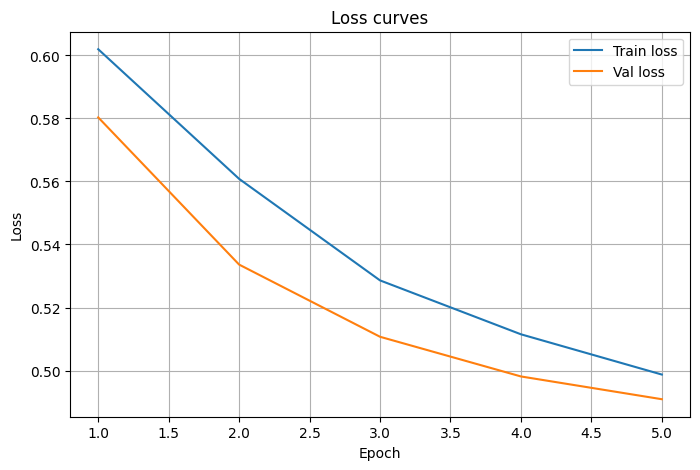

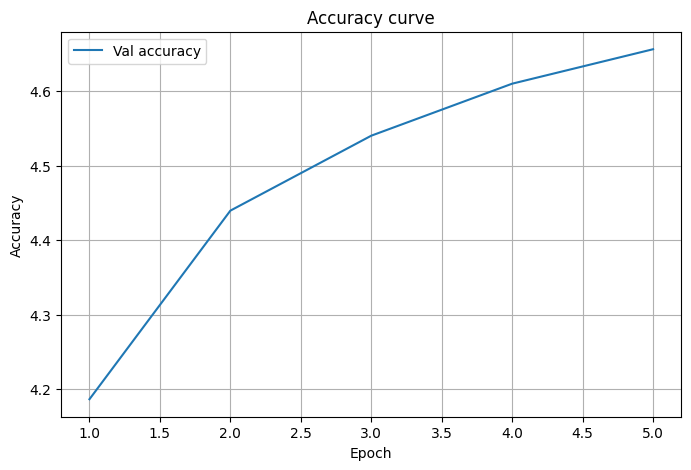

In [21]:
plot_history(history)

In [35]:
def evaluate_threshold(model, loader, device):
    import numpy as np
    
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            p = torch.softmax(out, dim=-1)[:,1].cpu().numpy()
            preds.extend(p)
            targets.extend(y.numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    best_th = 0.5
    best_acc = 0

    for th in np.linspace(0,1,101):
        yhat = (preds >= th).astype(int)
        acc = (yhat == targets).mean()
        if acc > best_acc:
            best_acc = acc
            best_th = th

    return best_th, best_acc


In [36]:
best_th, best_acc = evaluate_threshold(model, val_loader, device)
print(best_th, best_acc)


0.51 0.7762592592592592


In [37]:
import os
import csv
import torch
import torchaudio
from tqdm import tqdm

SAMPLE_RATE = 16000
WINDOW_SIZE = 1.5
HOP_SIZE = 0.5
EPS = 1e-9

PATH_TEST = "/kaggle/input/kws-test/test_opus/audio"
PATH_OUT = "submission.csv"

# ------- mel transform -------
mel_transform = transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    f_max=8000,
    n_mels=40
)

@torch.no_grad()
def predict_file(path):
    """
    Возвращает бинарный label по файлу:
    1 → если есть хотя бы одно окно с вероятностью >= 0.5
    0 → иначе
    """

    wav, sr = torchaudio.load(path)

    # resample if needed
    if sr != SAMPLE_RATE:
        wav = transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(wav)

    # mono
    wav = wav.mean(0, keepdim=True)

    win_len = int(WINDOW_SIZE * SAMPLE_RATE)
    hop_len = int(HOP_SIZE * SAMPLE_RATE)

    outputs = []

    # скользящее окно
    for start in range(0, wav.shape[1] - win_len + 1, hop_len):
        end = start + win_len
        seg = wav[:, start:end]

        # mel
        mel = mel_transform(seg)
        mel = (mel + EPS).log2()

        mel = mel.unsqueeze(0).to(device)  # [1, n_mels, time]

        pred = model(mel)
        prob = torch.softmax(pred, dim=-1)[1]  # вероятность класса 1

        outputs.append(prob)

    # если нет окон — выводим 0
    if len(outputs) == 0:
        return 0

    # решение: если есть окно с p>=0.51
    return int(max(outputs) >= 0.51)


In [40]:
test_files = [
    f for f in os.listdir(PATH_TEST)
    if f.endswith(".opus") and not f.startswith("._")
]

print(f"Found {len(test_files)} test audio files")

with open(PATH_OUT, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "label"])

    for fname in tqdm(test_files):
        uid = fname[:-5]  # remove .opus
        path = os.path.join(PATH_TEST, fname)
        
        label = predict_file(path)

        writer.writerow([uid, label])

print("\nSaved:", PATH_OUT)

Found 27000 test audio files


100%|██████████| 27000/27000 [26:22<00:00, 17.06it/s]


Saved: submission.csv


In [46]:
pd.read_csv('/kaggle/input/submission/submission.csv').sort_values(by='id').to_csv('submission.csv', index=False)